In [1]:
import cython

In [2]:
print(cython.__version__)

3.0.10


In [3]:
%load_ext cython

In [75]:
%%cython -f -a
# distutils: language = c++
# distutils: extra_compile_args = /std:c++20
# cython: boundscheck=False, wraparound=False, nonecheck=False, cdivision=True, initializedcheck=False
import numpy as np
cimport numpy as np

np.import_array()

from libc.stdio cimport printf
from libc.string cimport memcpy
from libcpp cimport bool as cpp_bool
from libcpp.limits cimport numeric_limits


from CyRK.utils.memory cimport shared_ptr, make_shared
from CyRK.utils.vector cimport vector
from CyRK.array.interp cimport interpj_ptr, interp_ptr, interp_complex_ptr
from CyRK cimport cysolve_ivp, CySolveOutput, PreEvalFunc, CySolverResult

from TidalPy.utilities.math.complex cimport cmplx_NAN, cf_build_dblcmplx

cdef double INF_DBL = numeric_limits[double].infinity()
cdef double PI_DBL = 3.14159265359
cdef double G = 6.67430e-11
cdef double NAN_DBL = cmplx_NAN.real

cdef struct interpolate_input:
    size_t num_slices
    double* radius_array_ptr
    double* density_array_ptr
    double complex* bulk_modulus_array_ptr
    double complex* shear_modulus_array_ptr

cdef struct EOSOutput:
    double density
    double complex bulk_modulus
    double complex shear_modulus

cdef void preeval_interpolate(
        # Values that will be updated by the function
        void* preeval_output,
        # Input that is used by the pre-eval
        double radius,
        double* radial_solutions,
        const void* preeval_input
        ) noexcept nogil:

    # Cast input to the proper structure for this function
    cdef EOS_ODEInput* ode_args = <EOS_ODEInput*>preeval_input
    cdef interpolate_input* eos_data = <interpolate_input*>ode_args.eos_input_ptr

    # Cast output to the proper structure
    cdef EOSOutput* output = <EOSOutput*>preeval_output

    # Set state variables based on an interpolation using the provided radius.
    # The first interpolation will be the slowest as it must find the closest index.
    # We will use this index in the other interpolations.
    cdef (double, Py_ssize_t) interp_out = interpj_ptr(
        radius,
        eos_data.radius_array_ptr,
        eos_data.density_array_ptr,
        eos_data.num_slices,
        provided_j=-2
        )

    cdef Py_ssize_t index_j
    output.density = interp_out[0]
    index_j        = interp_out[1]

    # TODO: Interpolate the static bulk and shear mod; interpolate the bulk and shear viscosity, then apply rheology here.
    cdef double complex complex_bulk
    if ode_args.update_bulk:
        complex_bulk = interp_complex_ptr(
            radius,
            eos_data.radius_array_ptr,
            eos_data.bulk_modulus_array_ptr,
            eos_data.num_slices,
            provided_j=index_j
            )
        
        output.bulk_modulus = complex_bulk
    else:
        output.bulk_modulus = cmplx_NAN

    cdef double complex complex_shear
    if ode_args.update_shear:
        complex_shear = interp_complex_ptr(
            radius,
            eos_data.radius_array_ptr,
            eos_data.shear_modulus_array_ptr,
            eos_data.num_slices,
            provided_j=index_j
            )

        # Apply shear rheology
        output.shear_modulus = complex_shear
    else:
        output.shear_modulus = cmplx_NAN

    # Done

        
cdef struct EOS_ODEInput:
    double G_to_use
    double planet_radius
    void* eos_input_ptr
    cpp_bool final_solve
    cpp_bool update_bulk
    cpp_bool update_shear


cdef struct GlobalEOSSolutionStorage:
    vector[double] radius
    vector[double] pressure
    vector[double] gravity
    vector[double] density
    vector[double] static_shear_modulus
    vector[double] shear_viscosity
    vector[double complex] complex_shear_modulus
    vector[double] static_bulk_modulus
    vector[double] bulk_viscosity
    vector[double complex] complex_bulk_modulus

ctypedef shared_ptr[GlobalEOSSolutionStorage] GlobalEOSSolution


cdef void eos_solution(
        double* dy_ptr,
        double radius,
        double* y_ptr,
        const void* input_args,
        PreEvalFunc eos_function) noexcept nogil:
    """ Solve for EOS components as a function of radius. """

    # Cast input args to correct structure type
    cdef EOS_ODEInput* eos_input_ptr = <EOS_ODEInput*>input_args

    # Other constants
    cdef double grav_coeff = 4. * PI_DBL * eos_input_ptr.G_to_use

    # Update viscoelastic parameters using the user-provided equation of state
    cdef EOSOutput eos_output
    cdef EOSOutput* eos_output_ptr = &eos_output 
    eos_function(eos_output_ptr, radius, y_ptr, input_args)
    
    cdef double rho = eos_output.density
    
    # Solve for gravity and pressure
    if (radius <= 0.0)  or (radius > eos_input_ptr.planet_radius):
        dy_ptr[0] = 0.0
        dy_ptr[1] = 0.0
    else:
        # Acceleration due to Gravity
        dy_ptr[0] = grav_coeff * rho - 2.0 * y_ptr[0] * (1.0 / radius)

        # Pressure
        dy_ptr[1] = -rho * y_ptr[0]

    # TODO: Track the static shear and bulk as well as the bulk and shear viscosity as additional outputs.
    if eos_input_ptr.final_solve:
        # There are two real dy/dt: gravity and pressure and then 9 additional parameters that are saved but
        # not used during integration but which the user may want for reference.
        dy_ptr[2] = eos_output.density

        dy_ptr[3] = eos_output.shear_modulus.real
        dy_ptr[4] = eos_output.shear_modulus.imag

        dy_ptr[5] = eos_output.bulk_modulus.real
        dy_ptr[6] = eos_output.bulk_modulus.imag

cdef vector[CySolveOutput] solve_eos(
        double* radius_array_ptr,
        size_t len_radius_array,
        double* layer_upper_radii,
        unsigned int num_layers,
        PreEvalFunc* eos_function_ptrs,
        EOS_ODEInput** eos_input_ptrs,
        double planet_bulk_density,
        double surface_pressure = 0.0,
        double G_to_use = G,
        unsigned int integration_method = 2,
        double rtol = 1.0e-6,
        double atol = 1.0e-8,
        double pressure_tol = 1.0e-3,
        unsigned int max_iters = 50
        ) noexcept nogil:

    # Don't use rtol or atol arrays
    cdef double* rtols_ptr = NULL
    cdef double* atols_ptr = NULL

    # Determine bounds
    cdef double planet_radius
    cdef double[2] radial_span
    cdef double* radial_span_ptr = &radial_span[0]
    radial_span_ptr[0] = radius_array_ptr[0]
    radial_span_ptr[1] = radius_array_ptr[len_radius_array - 1]
    planet_radius = radial_span_ptr[1]

    # We need the centeral pressure of the planet. Use the global bulk modulus to calculate this.
    cdef double centeral_gravity = 0.0
    cdef double centeral_pressure_guess = (4. / 3.) * PI_DBL * G_to_use * planet_radius * planet_radius * planet_bulk_density * planet_bulk_density
    cdef double[2] y0 = [centeral_gravity, centeral_pressure_guess]
    cdef double* y0_ptr = &y0[0]

    # y information
    cdef unsigned int num_y = 2
    cdef unsigned int num_extra = 0

    # Modify additional arguments to work with integrator
    cdef EOS_ODEInput eos_input
    cdef EOS_ODEInput* eos_input_ptr = &eos_input
    cdef void* args_ptr = <void*>eos_input_ptr

    # Other integration information
    cdef size_t max_num_steps = 10_000
    cdef size_t max_ram_MB = 500
    cdef bint use_dense_output = False
    cdef double max_step = 0.1 * planet_radius
    cdef double first_step = 0.0
    cdef size_t expected_size = 50

    # Solution information
    cdef double* t_eval_ptr = NULL
    cdef size_t len_t_eval = 0
    cdef CySolveOutput solution
    cdef CySolverResult* solution_ptr = NULL
    cdef double calculated_surf_pressure = INF_DBL
    cdef double pressure_diff = INF_DBL
    cdef size_t surface_pressure_index = 0
    cdef size_t iterations = 0
    cdef cpp_bool failed = False
    cdef cpp_bool max_iters_hit = False

    # Layer information
    cdef unsigned int layer_i
    cdef double[2] y0_layer = [centeral_gravity, centeral_pressure_guess]
    cdef double* y0_layer_ptr = &y0_layer[0]
    
    cdef EOS_ODEInput* eos_input_layer_ptr = NULL


    # Begin iterating until we find convergence on the surface pressure.
    cdef size_t i
    cdef size_t top_of_last_layer_index
    while (pressure_diff > pressure_tol) and (iterations < max_iters):

        # Step through each macro layer of the planet and solve for density and gravity
        for layer_i in range(num_layers):
            

            if layer_i == 0:
                radial_span_ptr[0] = 0.0
                # Set y0 equal to the global y0
                y0_layer_ptr[0] = y0_ptr[0]
                y0_layer_ptr[1] = y0_ptr[1]
            else:
                radial_span_ptr[0] = layer_upper_radii[layer_i - 1]
                top_of_last_layer_index = 2 * solution_ptr.size - 2
                y0_layer_ptr[0] = solution_ptr.solution[top_of_last_layer_index]
                y0_layer_ptr[1] = solution_ptr.solution[top_of_last_layer_index + 1]
            
            radial_span_ptr[1] = layer_upper_radii[layer_i]
            
            # Copy over the contents of the eos arg input so values can be manipulated
            eos_input_layer_ptr = eos_input_ptrs[layer_i]
            memcpy(eos_input_ptr, <void*>eos_input_layer_ptr, sizeof(EOS_ODEInput))
            # During the iterations we do not need to update the complex bulk or shear
            eos_input_ptr.update_bulk = False
            eos_input_ptr.update_shear = False
            # We also are not at the final call step. 
            eos_input_ptr.final_solve = False
            
            printf("\t\t LIND:: r_span = %e, %e\n", radial_span_ptr[0], radial_span_ptr[1])
            solution = cysolve_ivp(
                eos_solution, radial_span_ptr, y0_layer_ptr, num_y, integration_method, rtol, atol, args_ptr, num_extra,
                max_num_steps, max_ram_MB, use_dense_output, t_eval_ptr, len_t_eval, eos_function_ptrs[layer_i],
                rtols_ptr, atols_ptr, max_step, first_step, expected_size)
            solution_ptr = solution.get()

            radial_span_ptr[0] = radial_span_ptr[1]

            if not solution_ptr.success:
                failed = True
                break

        if failed:
            break

        surface_pressure_index = 2 * solution_ptr.size - 1
        printf("DEBUG:: Integration Msg: %s\n", solution_ptr.message_ptr)
        printf("DEBUG:: Size = %d\n", solution_ptr.size)
        for i in range(solution_ptr.size):
            printf("\t %d:: r = %e g = %e P = %e\n", 2 * i + 1, solution_ptr.time_domain[i], solution_ptr.solution[2 * i], solution_ptr.solution[2 * i + 1])
        calculated_surf_pressure = solution_ptr.solution[surface_pressure_index]

        # Update the centeral pressure using the error at the surface as the correction factor
        pressure_diff = surface_pressure - calculated_surf_pressure
        printf("DEBUG:: S = %e; D = %e\n", calculated_surf_pressure, pressure_diff)
        y0_ptr[1] += pressure_diff

        # Calculate percent difference to use in loop check.
        if pressure_diff < 0.0:
            pressure_diff = -pressure_diff

        if surface_pressure != 0.0:
            pressure_diff /= surface_pressure

        iterations += 1

        if iterations > max_iters:
            max_iters_hit = True
            break
    
    # Display any warnings
    if max_iters_hit:
        printf("Warning in `solve_eos`: Maximum number of iterations hit without convergence.\n")
    
    if failed:
        if solution_ptr:
            printf("Warning in `solve_eos`: Integrator failed at iteration %d. Message: %s\n", iterations, solution_ptr.message_ptr)
        else:
            printf("Warning in `solve_eos`: Integrator failed at iteration %d.\n", iterations)
    
    printf("Max Iters = %d\n", iterations)

    # Solve one last time using the provided radius array as our target steps
    radial_span_ptr[0] = radius_array_ptr[0]

    # Parameters to set t_eval
    cdef double radius_check
    cdef cpp_bool found_start = False
    cdef cpp_bool found_end = False
    cdef size_t slice_i = 0
    cdef double start_radius = 0.0
    cdef double end_radius = 0.0
    cdef size_t t_eval_start_index = 0
    cdef size_t num_t_eval = 0

    # Also save additional data calculated during integration
    num_extra = 5

    # Step through each macro layer of the planet. Store solutions in a vector
    cdef vector[CySolveOutput] layer_solutions = vector[CySolveOutput](0)
    layer_solutions.reserve(num_layers)

    for layer_i in range(num_layers):

        if layer_i == 0:
            start_radius = 0.0
        else:
            start_radius = layer_upper_radii[layer_i - 1]
        if layer_i == (num_layers - 1):
            end_radius = planet_radius
        else:
            end_radius = layer_upper_radii[layer_i + 1]
        
        found_start = False
        found_end = False
        num_t_eval = 0
        for slice_i in range(len_radius_array):
            if found_start and found_end:
                break
            radius_check = radius_array_ptr[slice_i]

            if radius_check >= start_radius:
                
                if not found_start:
                    t_eval_ptr  = &radius_array_ptr[slice_i]
                    found_start = True
                
                if radius_check < end_radius:
                    # Still in layer
                    num_t_eval += 1
                elif radius_check == end_radius:
                    # At very top of layer. If the last layer then save this data point. Otherwise push it to next layer.
                    if layer_i == (num_layers - 1):
                        num_t_eval += 1
                        found_end = True
                    else:
                        found_end = True
                else:
                    found_end = True

        radial_span_ptr[1] = layer_upper_radii[layer_i]
        
        if layer_i == 0:
            # Set y0 equal to the global y0
            y0_layer_ptr[0] = y0_ptr[0]
            y0_layer_ptr[1] = y0_ptr[1]
        
        # Copy over the contents of the eos arg input so values can be manipulated
        eos_input_layer_ptr = eos_input_ptrs[layer_i]
        memcpy(eos_input_ptr, <void*>eos_input_layer_ptr, sizeof(EOS_ODEInput))

        # We now want to make sure that all final calculations are performed.
        eos_input_ptr.update_bulk = True
        eos_input_ptr.update_shear = True
        eos_input_ptr.final_solve = True

        solution = cysolve_ivp(
            eos_solution, radial_span_ptr, y0_ptr, num_y, integration_method, rtol, atol, args_ptr, num_extra,
            max_num_steps, max_ram_MB, use_dense_output, t_eval_ptr, len_t_eval, eos_function_ptrs[layer_i],
            rtols_ptr, atols_ptr, max_step, first_step, expected_size)
        
        layer_solutions.push_back(solution)

        radial_span_ptr[0] = radial_span_ptr[1]
    
    return layer_solutions


cdef double R_P = 6000.e3
cdef unsigned int num_layers = 1
cdef double planet_bulk_density = 3500.
cdef double surface_pressure = 0.0
cdef double G_to_use = G
cdef unsigned int integration_method = 2
cdef double rtol = 1.0e-6
cdef double atol = 1.0e-8
cdef double pressure_tol = 1.0e-3
cdef unsigned int max_iters = 50

cdef double[1] layer_upper_radii = [R_P]
cdef double* layer_upper_radii_ptr = &layer_upper_radii[0]

cdef size_t len_radius_array = 10
cdef double[::1] radius_array_view = np.linspace(0.0, R_P, 10)
cdef double* radius_array_ptr = &radius_array_view[0]

cdef double[::1] density_array_view = np.linspace(4000., 2000, 10)
cdef double* density_array_ptr = &density_array_view[0]

cdef double complex[::1] shear_array_view = np.linspace(100.0e9, 75.0e9, 10, dtype=np.complex128)
cdef double complex* shear_array_ptr = &shear_array_view[0]

cdef double complex[::1] bulk_array_view = np.linspace(200.0e9, 175.0e9, 10, dtype=np.complex128)
cdef double complex* bulk_array_ptr = &bulk_array_view[0]

cdef PreEvalFunc[1] eos_function_bylayer = [preeval_interpolate]
cdef PreEvalFunc* eos_function_ptrs = &eos_function_bylayer[0]

cdef interpolate_input eos_input

eos_input.num_slices = len_radius_array
eos_input.radius_array_ptr = radius_array_ptr
eos_input.density_array_ptr = density_array_ptr
eos_input.bulk_modulus_array_ptr = bulk_array_ptr
eos_input.shear_modulus_array_ptr = shear_array_ptr

cdef interpolate_input* eos_preeval_input_ptr = &eos_input

cdef EOS_ODEInput eos_ode_input

eos_ode_input.G_to_use = G
eos_ode_input.planet_radius = R_P
eos_ode_input.eos_input_ptr = <void*>eos_preeval_input_ptr

eos_ode_input.final_solve = False
eos_ode_input.update_bulk = False
eos_ode_input.update_shear = False


cdef EOS_ODEInput* eos_ode_input_ptr = &eos_ode_input
cdef EOS_ODEInput* eos_ode_input_layers= [eos_ode_input_ptr, eos_ode_input_ptr]

cdef EOS_ODEInput** eos_ode_input_layers_ptr = &eos_ode_input_ptr

cdef vector[CySolveOutput] Output
Output = solve_eos(
        radius_array_ptr,
        len_radius_array,
        layer_upper_radii_ptr,
        num_layers,
        eos_function_ptrs,
        eos_ode_input_layers_ptr,
        planet_bulk_density,
        surface_pressure,
        G_to_use,
        integration_method,
        rtol,
        atol,
        pressure_tol,
        max_iters
        )

printf("DEBUG: %s\n", Output[0].get().message_ptr)

x = np.asarray(Output[0].get().time_domain)
y = np.asarray(Output[0].get().solution)

print()
print(x.shape)
print(y.shape)


Error compiling Cython file:
------------------------------------------------------------
...
eos_ode_input.update_bulk = False
eos_ode_input.update_shear = False


cdef EOS_ODEInput* eos_ode_input_ptr = &eos_ode_input
cdef EOS_ODEInput* eos_ode_input_layers[2] = [eos_ode_input_ptr, eos_ode_input_ptr]
                                           ^
------------------------------------------------------------

C:\Users\joepr\.ipython\cython\_cython_magic_e54845507f10a8626903e0cb261e877453b80075.pyx:465:43: Syntax error in C variable declaration


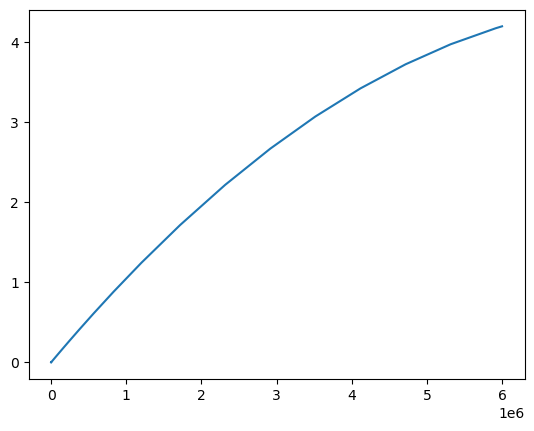

In [73]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y2 = y.reshape((x.size,7)).T

ax.plot(x, y2[0])

In [58]:
y2

array([[ 0.00000000e+00, -6.42434477e-11,  2.12329656e-10,
         6.10847404e-10,  1.69754775e-09,  5.35252789e-09,
         1.98021532e-08,  8.90963772e-08,  5.11310723e-07,
         4.21343374e-06,  2.42291644e-05,  1.06061718e-04,
         3.69417105e-04,  1.06341658e-03,  2.62632536e-03,
         5.76177451e-03,  1.15578548e-02,  2.16700234e-02,
         3.85710748e-02,  6.58608315e-02,  1.08626943e-01,
         1.73838068e-01,  2.70721442e-01,  4.11024112e-01,
         6.08972193e-01,  8.80613758e-01,  1.24207637e+00,
         1.70646897e+00,  2.28273971e+00,  2.98340812e+00,
         3.77380209e+00,  4.19358637e+00],
       [ 1.23291439e+11,  1.23291439e+11,  1.23291439e+11,
         1.23291439e+11,  1.23291439e+11,  1.23291439e+11,
         1.23291439e+11,  1.23291439e+11,  1.23291439e+11,
         1.23291439e+11,  1.23291439e+11,  1.23291439e+11,
         1.23291439e+11,  1.23291437e+11,  1.23291427e+11,
         1.23291380e+11,  1.23291200e+11,  1.23290599e+11,
         1.23